# Import Libraries

In [1]:
#!pip install --upgrade scipy
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
from scipy.special import betainc

# Define Functions

In [2]:
# Function to load NIfTI images
def load_nii(filename):
    return nib.load(filename)


# Function for power calculations
def power_calcs2(df1, df2, cohens_f2, alpha):

    Fcrit = f.ppf(1 - alpha, df1, df2) # returns the inverse cumulative distribution function of the F distribution with degrees of freedom df1 and df2, evaluated at the probability value of 1 - alpha

    lambda_ = (df1 + df2 + 1) * cohens_f2
    kappa = (df1 + lambda_) / df1
    df2_lambda = ((df1 + lambda_) ** 2) / (df1 + 2 * lambda_)

    F_prime = Fcrit / kappa
    x = (df2_lambda * F_prime) / (df2 + df2_lambda * F_prime)
    beta = betainc(df2_lambda / 2, df2 / 2, x)

    power = 1 - beta

    return {"power": power, "cohens_f2": cohens_f2}

# Power Plots
### Looped for each f2 and degrees of freedom

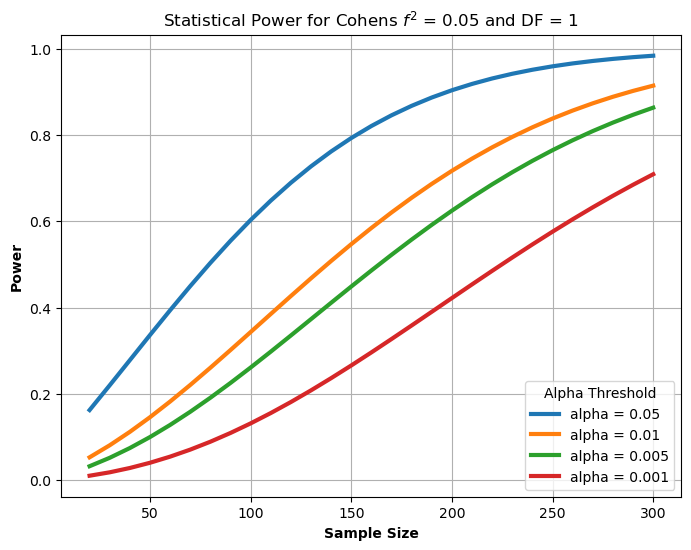

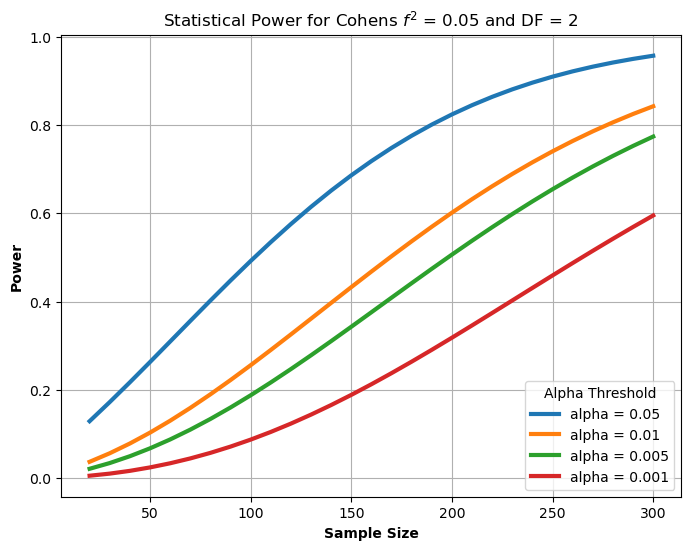

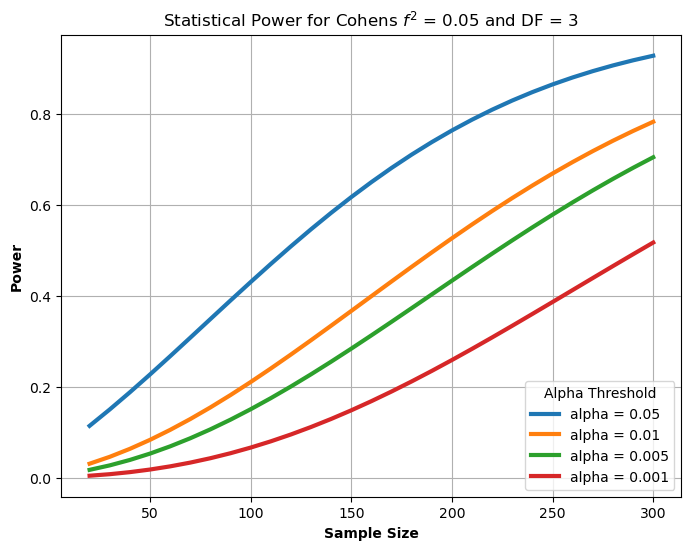

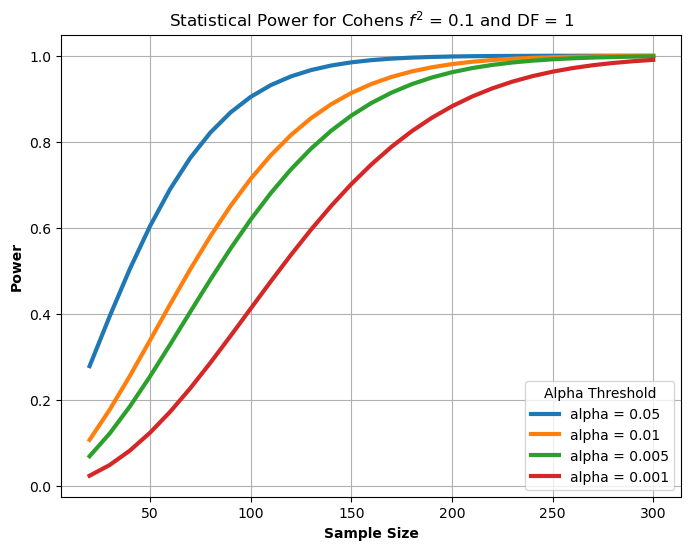

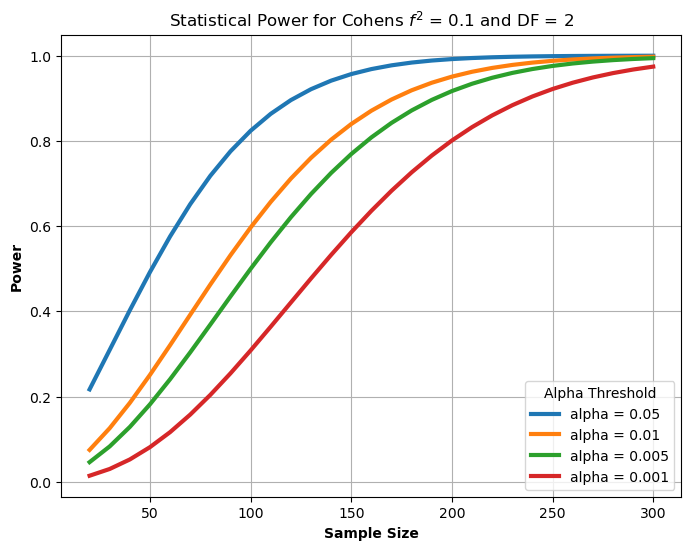

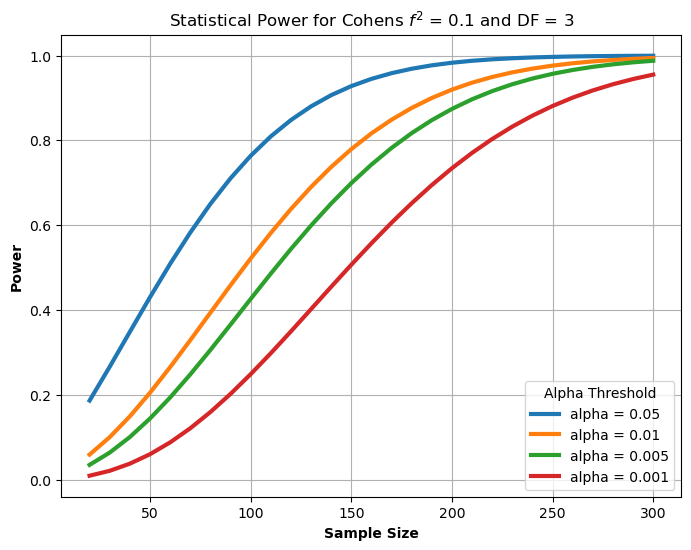

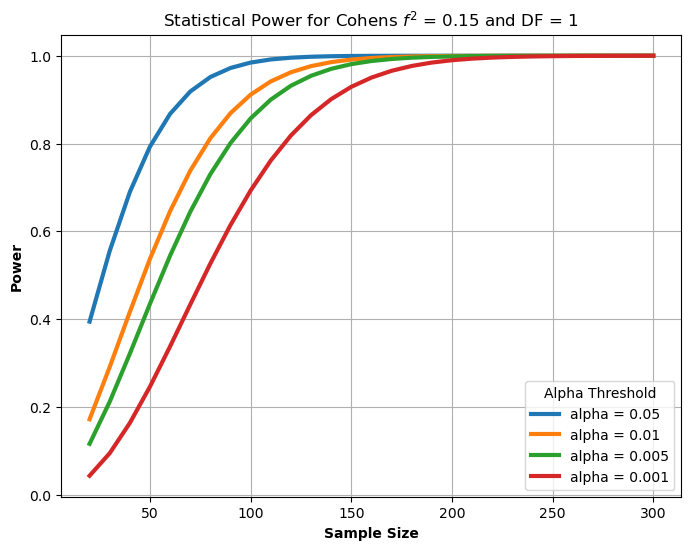

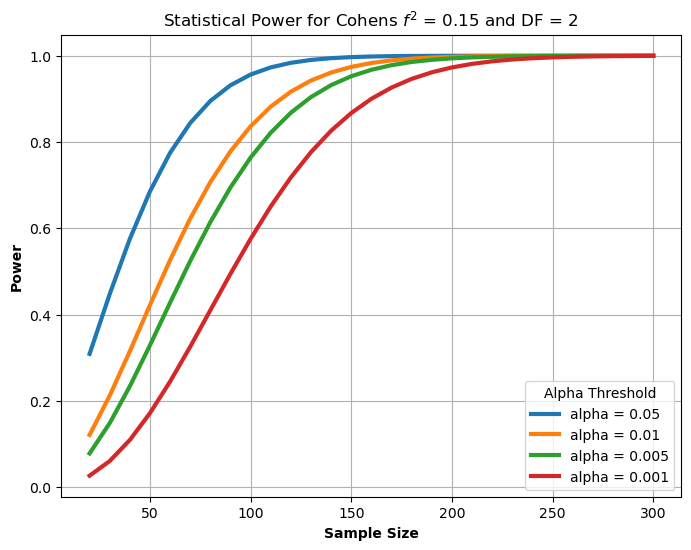

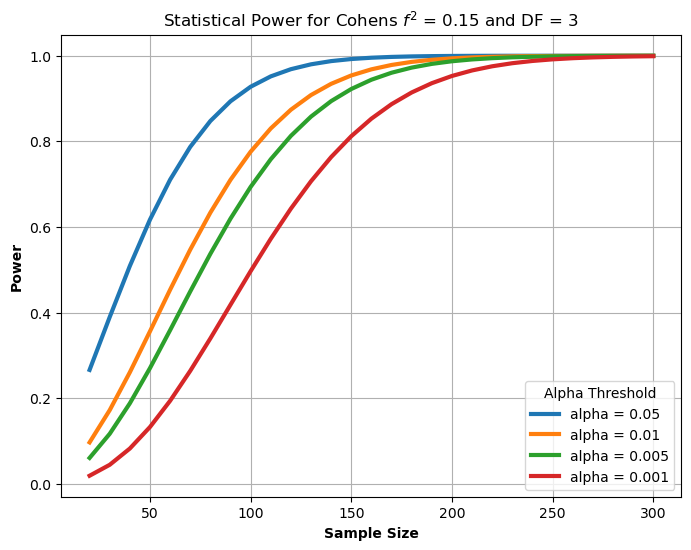

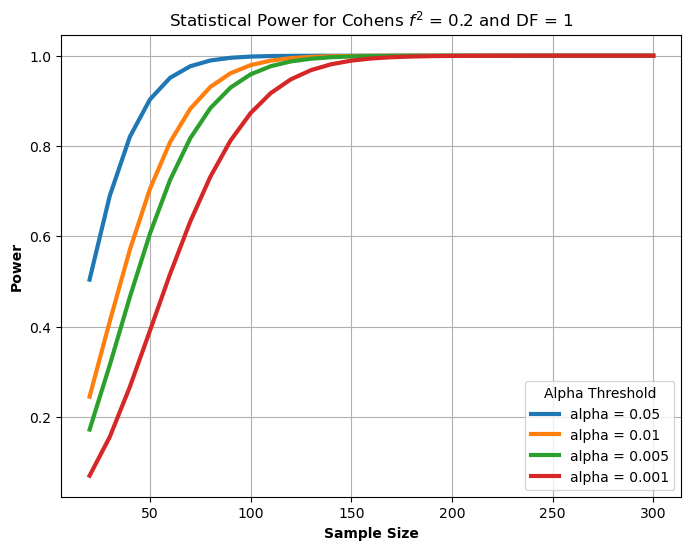

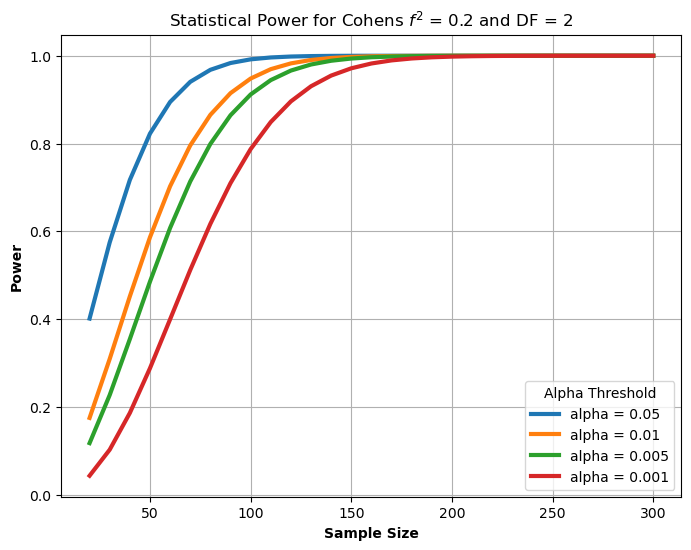

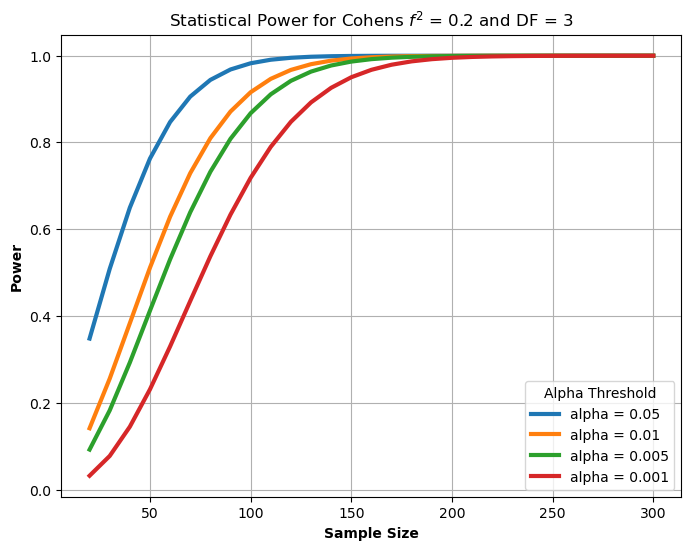

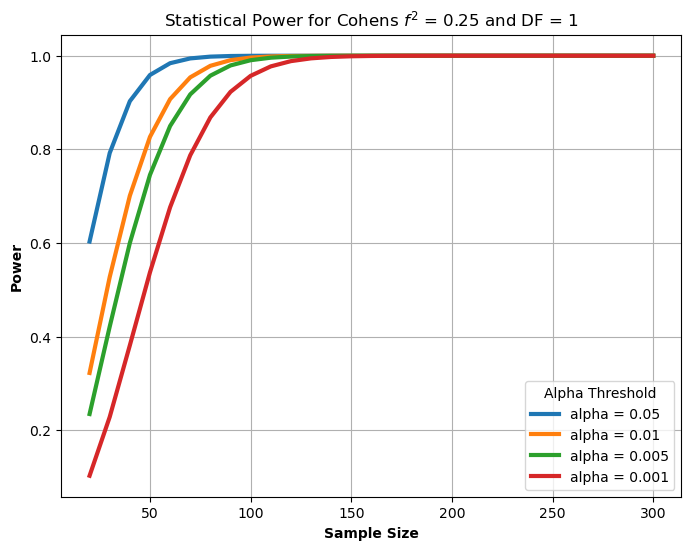

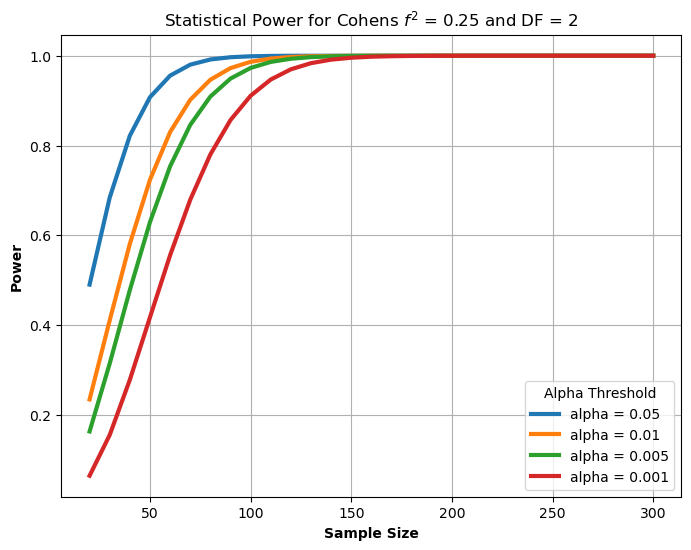

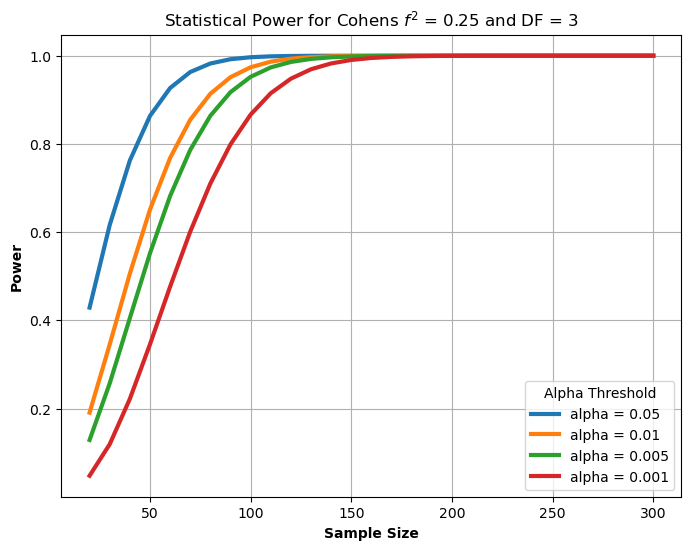

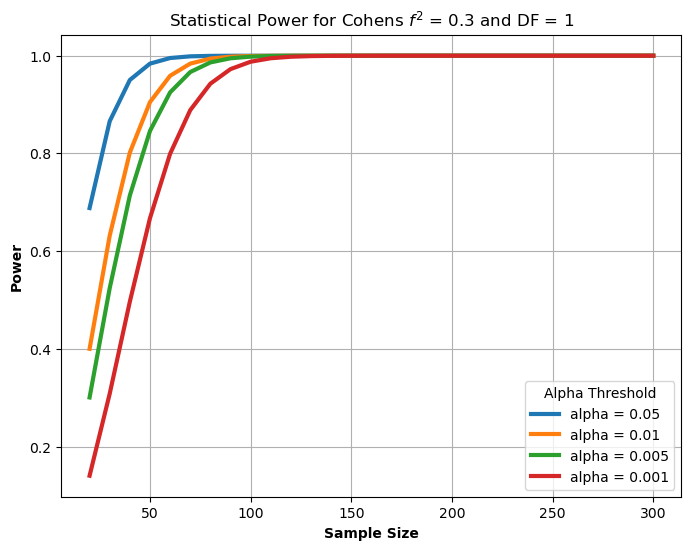

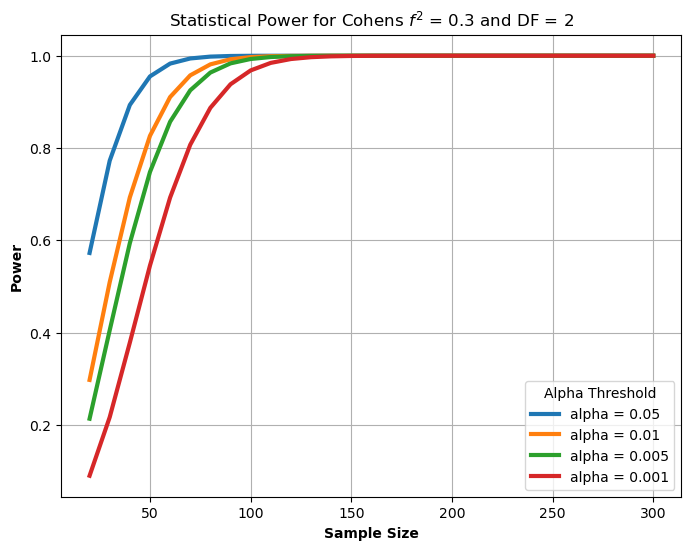

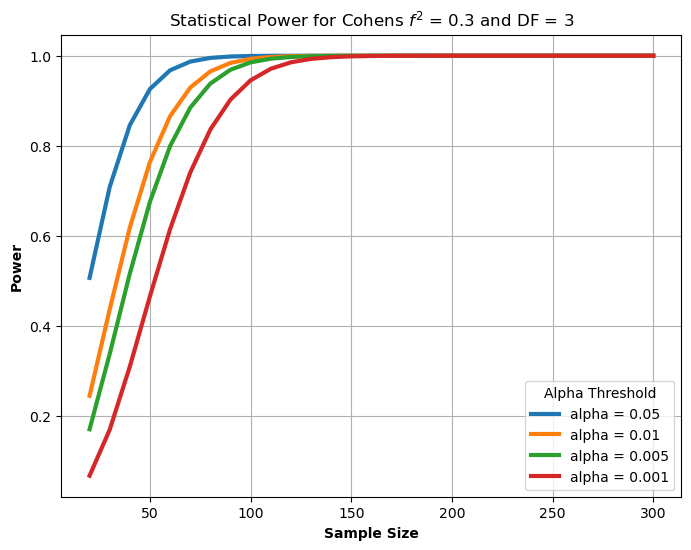

In [3]:
# Define parameters
d = [0.05, 0.01, 0.005, 0.001]
f2 = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
df = [1, 2, 3]
n_values = np.arange(20, 310, 10) #sample sized from 20 to 310 in intervals of 10

for a in f2:
    for b in df:
        # Initialize power matrix
        P = np.zeros((len(d), len(n_values))) # matrix of size (#  of alphas by # of sample sizes)

        # Compute statistical power
        for i, alpha in enumerate(d):
            for j, n in enumerate(n_values):
                stat_power = power_calcs2(b, n, a, alpha)
                P[i, j] = stat_power['power']

        # Plot results
        plt.figure(figsize=(8, 6))
        for i in range(len(d)):
            plt.plot(n_values, P[i, :], linewidth=3, label=f'alpha = {d[i]}')

            plt.title(f'Statistical Power for Cohens $f^2$ = {a} and DF = {b}')
            plt.ylabel('Power', fontweight='bold')
            plt.xlabel('Sample Size', fontweight='bold')
            plt.legend(title='Alpha Threshold', loc='lower right')
            plt.grid(True)
            plt.savefig(f'plots/Statistical_Power_for_Cohens_f2__{a}_df_{b}.png')

# Contrast Images 
### Looped for each f2, power, sample size (N), and alpha

In [4]:
f2 = [0.1, 0.2, 0.3]
d = [0.05]

# Load fMRI images
MNIAtlas = load_nii('anatomical.nii.gz')
Contrast1 = load_nii('language_uniformity-test_z_FDR_0.01.nii.gz')
#Contrast2 = load_nii('language_association_test_z_FDR_0.01.nii.gz')

# Extract image data
Contrast1_img = Contrast1.get_fdata()
#Contrast2_img = Contrast2.get_fdata()

# Compute max contrast
MaxContrast1 = np.max(Contrast1_img)
#MaxContrast2 = np.max(Contrast2_img)

for a in f2:
    # Scale contrast images
    Contrast1_Scaled = (a / MaxContrast1) * Contrast1_img
    #Contrast2_Scaled = (a / MaxContrast2) * Contrast2_img ###Contrast 2 never used

    # Get image dimensions correctly
    XDIM, YDIM, ZDIM = Contrast1_img.shape
    PowerImage1 = np.zeros((XDIM, YDIM, ZDIM))

    # Power analysis
    PowerThreshold = [0.90]#[0.80, 0.85, 0.90, 0.95]  # Needs to be decimal
    Ns = [150]#[50, 100, 150, 200]

    for p in PowerThreshold:
        for n in Ns:
            for alpha in d:
                for i in range(XDIM):
                    for j in range(YDIM):
                        for k in range(ZDIM):
                            if Contrast1_Scaled[i, j, k] > 0:
                                stat_power = power_calcs2(1, n, Contrast1_Scaled[i, j, k], alpha) # only calculate power on non-0 values
                                if stat_power['power'] >= p:
                                    PowerImage1[i, j, k] = stat_power['power'] #adjusts 3d matrix on values to only include power values that meet threshold (overwrites default zeros)

                # Format filename correctly
                pvalue = str(alpha).replace('0.', '')
                f2value = str(a).replace('0.', '0')
                filename = f'images/Contrast1_Power_N{n}_p{pvalue}_Power{int(p * 100)}_f2{f2value}.nii.gz'

                # Save power image as a NIfTI file
                PowerImage_nii = nib.Nifti1Image(PowerImage1, Contrast1.affine, Contrast1.header)
                nib.save(PowerImage_nii, filename)

### What about Contrast 2?


# Activation Maps

## My Data

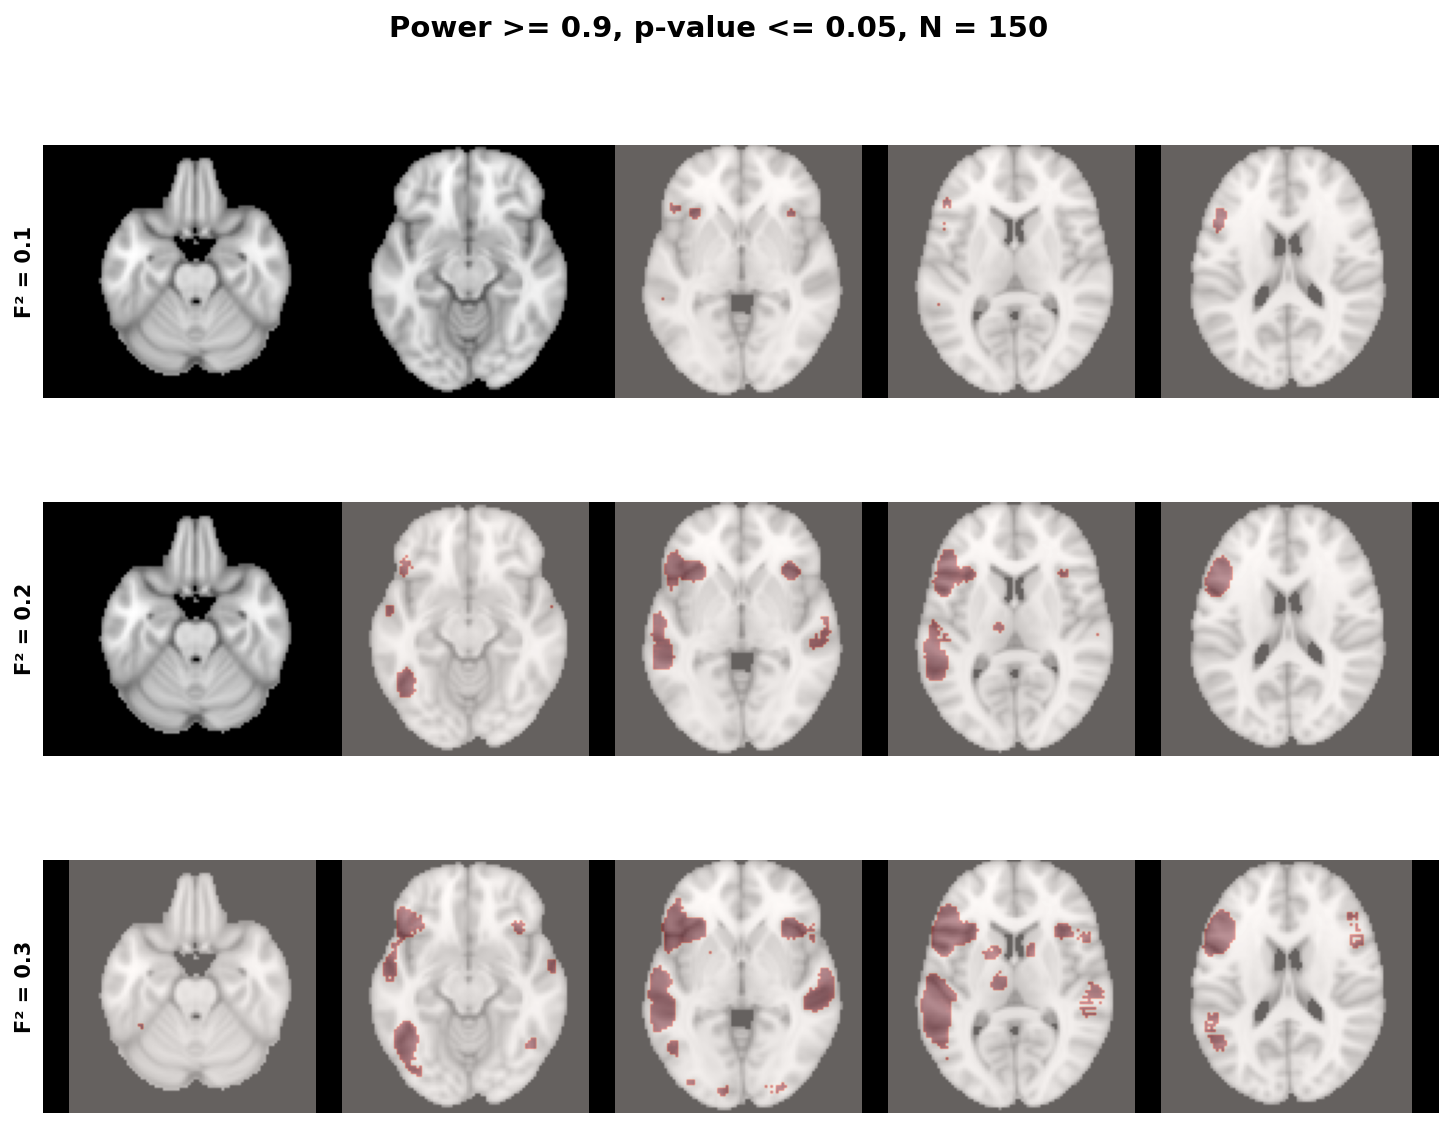

In [5]:
from scipy.ndimage import rotate
import nibabel as nib
import numpy as np
import re
import matplotlib.pyplot as plt

# Define the activation files
activation_files = [
    'images/Contrast1_Power_N150_p05_Power90_f201.nii.gz',
    'images/Contrast1_Power_N150_p05_Power90_f202.nii.gz',
    'images/Contrast1_Power_N150_p05_Power90_f203.nii.gz'
]

# Load the anatomical image
img = nib.load('anatomical.nii.gz')
data = img.get_fdata()

# Define slices to extract
slices_indices = [24, 30, 35, 40, 45]

# Set up the figure
fig, axes = plt.subplots(len(activation_files), len(slices_indices), figsize=(12, 9), dpi=150)

# Loop through activation files
for row, activation_file in enumerate(activation_files):
    # Load activation data
    activation = nib.load(activation_file)
    activation_data = activation.get_fdata()
    
    # Extract metadata from filename
    match = re.search(r'images/Contrast1_Power_N(\d+)_p(\d+)_Power(\d+)_f2(\d+)', activation_file)
    if match:
        f_value = float(match.group(4)) / 10
        n_value = match.group(1)
        p_value = float(match.group(2)) / 100
        power_value = float(match.group(3)) / 100
        title_text = f"Power >= {power_value}, p-value <= {p_value}, N = {n_value}"
    else:
        f_value = None
    
    # Loop through slices
    for col, slice_idx in enumerate(slices_indices):
        slice_img = data[:, :, slice_idx]
        activation_img = activation_data[:, :, slice_idx]
        
        # Rotate images by 90 degrees
        rotated_slice = np.flip(rotate(slice_img, 90, reshape=False, mode='constant', cval=0), axis=1)
        rotated_activation = np.flip(rotate(activation_img, 90, reshape=False, mode='constant', cval=0), axis=1)

        
        ax = axes[row, col] if len(activation_files) > 1 else axes[col]
        ax.imshow(rotated_slice, cmap='gray')
        ax.imshow(np.ma.masked_where(rotated_activation == 0, rotated_activation), cmap='Reds', alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        
        # Set y-axis titles
        if col == 0 and f_value is not None:
            ax.set_ylabel(f"F² = {f_value}", fontsize=10, fontweight='bold')

fig.suptitle(title_text, fontsize=14, fontweight='bold', y=0.95)
plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.show()


## Jack's Data from Matlab

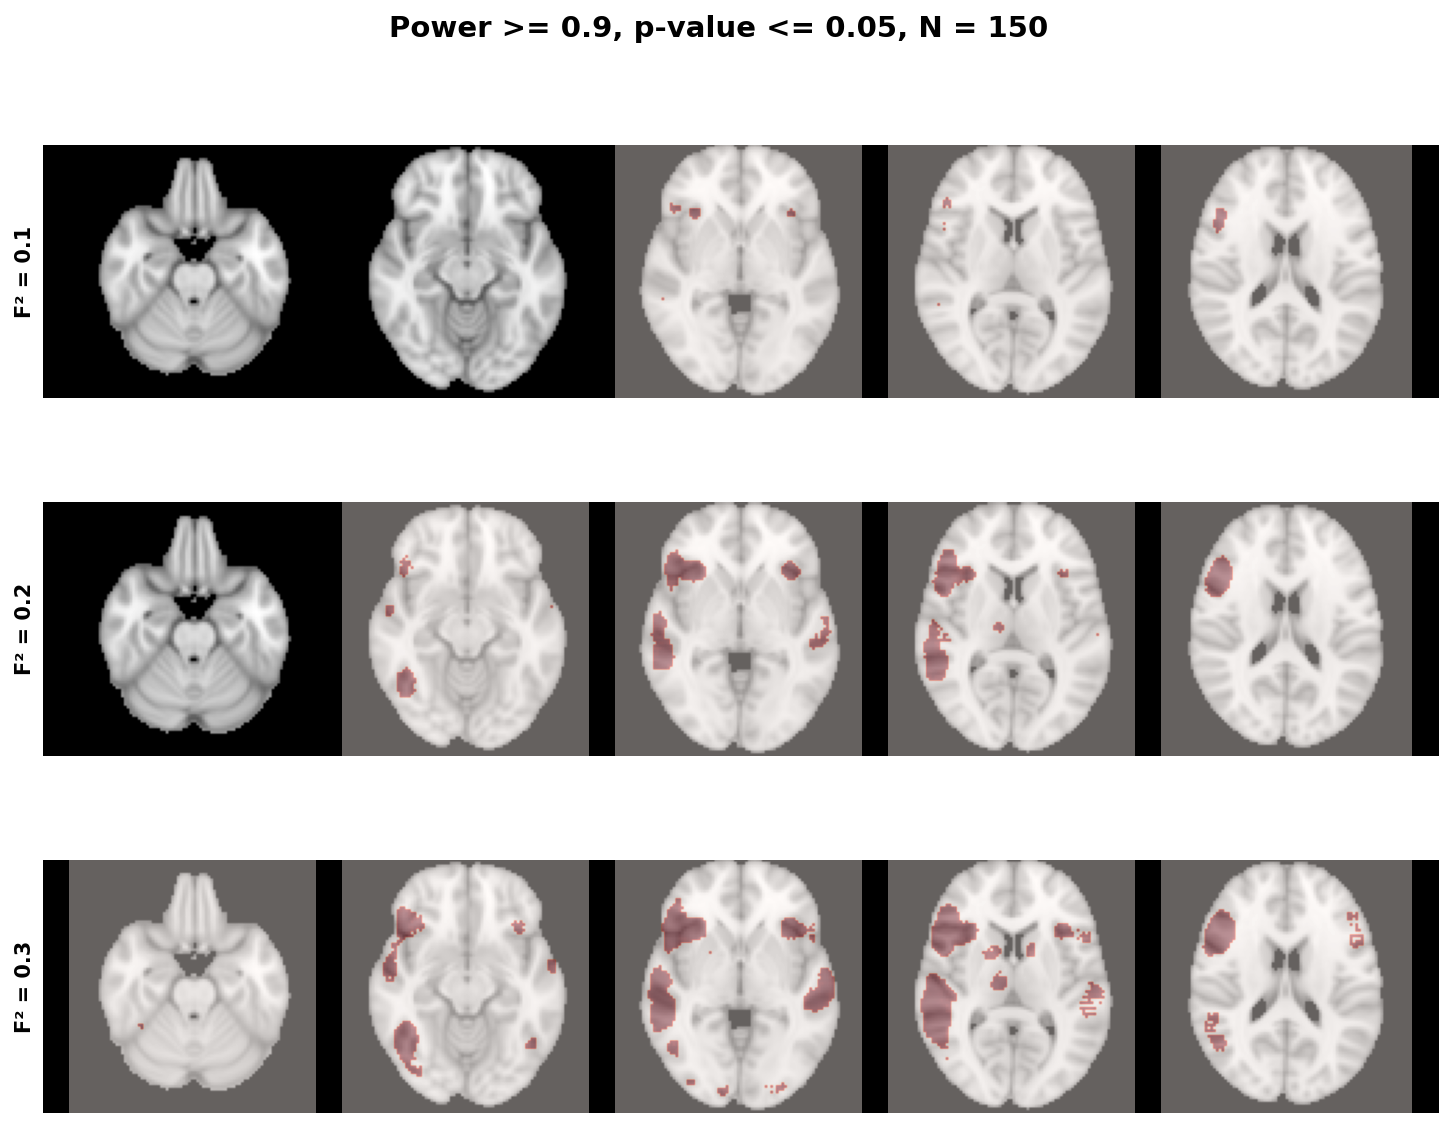

In [7]:
from scipy.ndimage import rotate
import nibabel as nib
import numpy as np
import re
import matplotlib.pyplot as plt

# Define the activation files
activation_files = [
    'matlab_created_images/Contrast1_Power_N150_p05_Power90_f2_01.img',
    'matlab_created_images/Contrast1_Power_N150_p05_Power90_f2_02.img',
    'matlab_created_images/Contrast1_Power_N150_p05_Power90_f2_03.img'
]

# Load the anatomical image
img = nib.load('anatomical.nii.gz')
data = img.get_fdata()

# Define slices to extract
slices_indices = [24, 30, 35, 40, 45]

# Set up the figure
fig, axes = plt.subplots(len(activation_files), len(slices_indices), figsize=(12, 9), dpi=150)

# Loop through activation files
for row, activation_file in enumerate(activation_files):
    # Load activation data
    activation = nib.load(activation_file)
    activation_data = activation.get_fdata()
    
    # Extract metadata from filename
    match = re.search(r'images/Contrast1_Power_N(\d+)_p(\d+)_Power(\d+)_f2_(\d+)', activation_file)
    if match:
        f_value = float(match.group(4)) / 10
        n_value = match.group(1)
        p_value = float(match.group(2)) / 100
        power_value = float(match.group(3)) / 100
        title_text = f"Power >= {power_value}, p-value <= {p_value}, N = {n_value}"
    else:
        f_value = None
    
    # Loop through slices
    for col, slice_idx in enumerate(slices_indices):
        slice_img = data[:, :, slice_idx]
        activation_img = activation_data[:, :, slice_idx]
        
        # Rotate images by 90 degrees
        rotated_slice = rotate(slice_img, 90, reshape=False, mode='constant', cval=0)
        rotated_activation = rotate(activation_img, 90, reshape=False, mode='constant', cval=0)
        
        ax = axes[row, col] if len(activation_files) > 1 else axes[col]
        ax.imshow(rotated_slice, cmap='gray')
        ax.imshow(np.ma.masked_where(rotated_activation == 0, rotated_activation), cmap='Reds', alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        
        # Set y-axis titles
        if col == 0 and f_value is not None:
            ax.set_ylabel(f"F² = {f_value}", fontsize=10, fontweight='bold')

fig.suptitle(title_text, fontsize=14, fontweight='bold', y=0.95)
plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.show()


# Second Generation P-Value

In [9]:
import scipy.stats as st

def z_score_from_alpha(alpha, tail='two-sided'):
    """
    Calculates the z-score from a given alpha value.

    Parameters:
    alpha (float): Significance level (e.g., 0.05).
    tail (str): Type of test tail ('two-sided', 'left', or 'right').
                  Defaults to 'two-sided'.

    Returns:
    float: Z-score corresponding to the alpha value.
    """
    if tail == 'two-sided':
        z = st.norm.ppf(1 - alpha/2)
    elif tail == 'left':
        z = st.norm.ppf(alpha)
    elif tail == 'right':
         z = st.norm.ppf(1 - alpha)
    else:
        raise ValueError("tail must be 'two-sided', 'left', or 'right'")
    return z

In [17]:
alpha =  0.05

def calculate_second_gen_p_value(observed_effect, null_hypothesis, effect_interval, alpha):
    """
    Calculate second-generation p-value for neuroimaging data
    
    Parameters:
        observed_effect (float): Estimated effect size from neuroimaging analysis
        null_hypothesis (float): Point null hypothesis value #### this should be the mean of the population (which for fmri is 0?)
        effect_interval (float): Interval of practically equivalent effects
    
    Returns:
        tuple: (delta_p, interpretation)
    """
    # Define confidence interval (example: 95% CI)
    confidence_level = 1-alpha
    z_score = round(z_score_from_alpha(alpha, tail='two-sided'),2)
    #print(z_score)
    
    # Hypothetical standard error (would be calculated from actual data)
    std_error = abs(observed_effect - null_hypothesis) / z_score
    #print(std_error)
    
    #CI of each voxel
    # Lower and upper bounds of confidence interval
    ci_lower = observed_effect - (z_score * std_error)
    #print(ci_lower)
    ci_upper = observed_effect + (z_score * std_error)
    #print(ci_upper)
    
    #H0 of overall study
    # Lower and upper bounds of effect interval
    interval_lower = null_hypothesis - effect_interval
    #print(interval_lower)
    interval_upper = null_hypothesis + effect_interval
    #print(interval_upper)
    
    # Calculate second-generation p-value
    if ci_upper <= interval_upper and ci_lower >= interval_lower: #CI entirely contained in the indifference zone (interval)
        # Conclusive evidence against null
        delta_p = 1.0
        interpretation = 'The data supports the null hypothesis - not scientifically or clinically meaningful'
    elif ci_upper < interval_lower or ci_lower > interval_upper: #absolutely no overlap of CI with the indifference zone 
        # Confidence interval completely covers equivalence interval
        delta_p = 0.0
        interpretation = 'The data supports an alternative hypothesis that is scientifically OR clinically meaningful'
    elif (ci_upper - ci_lower) > (2*(interval_upper-interval_lower)): 
        # Confidence interval more than twice the length of the null interval (p.4 and top p.6)
        delta_p = 0.5
        interpretation = 'Data is strictly inconclusive'
    else: 
        # Confidence interval less than twice the length of the null interval (p.4)
        # Partial overlap (either above or below null interval) - ### is there a situation in which it could be both?
        overlap_lower = max(ci_lower, interval_lower)
        overlap_upper = min(ci_upper, interval_upper)
        
        # Calculate proportion of overlap
        delta_p = (overlap_upper - overlap_lower) / (ci_upper - ci_lower)
        interpretation = 'Partial evidence, some consistency with null' #overlap fraction
    
    '''
    # Visualize the result
    plt.figure(figsize=(8, 4))
    plt.plot([ci_lower, ci_upper], [1, 1], 'b-', linewidth=2, label='Observed Value CI')
    plt.plot([interval_lower, interval_upper], [0.5, 0.5], 'r-', linewidth=2, label='Indifference Zone')
    plt.title('Second-Generation P-Value Visualization')
    plt.xlabel('Effect Size')
    plt.yticks([])
    plt.legend()
    plt.show()

    
    # Display numerical results
    print(f'Second-Generation P-Value: {delta_p:.4f}')
    print(ci_lower)
    print(ci_upper)
    print(f'Interpretation: {interpretation}')
    '''        
    return delta_p


for i in [141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151]:
    calculate_second_gen_p_value(i, 146, 2, 0.05)


In [18]:
alpha = 0.05
effect_interval= 4

# Load fMRI images
MNIAtlas = load_nii('anatomical.nii.gz')
Contrast1 = load_nii('language_uniformity-test_z_FDR_0.01.nii.gz')
#Contrast2 = load_nii('language_association_test_z_FDR_0.01.nii.gz')

# Extract image data
Contrast1_img = Contrast1.get_fdata()
#Contrast2_img = Contrast2.get_fdata()
print(Contrast1_img.min())
print(Contrast1_img.max())
print(Contrast1_img.mean())

null_hypothesis = Contrast1_img.mean()


# Get image dimensions correctly
XDIM, YDIM, ZDIM = Contrast1_img.shape
PowerImage1 = np.zeros((XDIM, YDIM, ZDIM))

for i in range(XDIM):
    for j in range(YDIM):
        for k in range(ZDIM):
            if Contrast1_img[i, j, k] > 0:
                delta_p = calculate_second_gen_p_value(Contrast1_img[i, j, k], null_hypothesis, effect_interval, alpha) # only calculate on non-0 values
                if delta_p < 0.5:
                    PowerImage1[i, j, k] = 1 #adjusts 3d matrix on values to only include power values that meet threshold (overwrites default zeros)

# Format filename correctly
pvalue = str(alpha).replace('0.', '')
filename = f'images/Contrast1_p{pvalue}_SecondGenP.nii.gz'
print(PowerImage1.flatten().min())
print(PowerImage1.flatten().max())
print(PowerImage1.flatten().mean())

# Save power image as a NIfTI file
PowerImage_nii = nib.Nifti1Image(PowerImage1, Contrast1.affine, Contrast1.header) ###### something isn't translating correctly here
nib.save(PowerImage_nii, filename)



-4.097555546880355
33.11195190498638
0.1352394630014648
0.0
1.0
0.016024302343487746


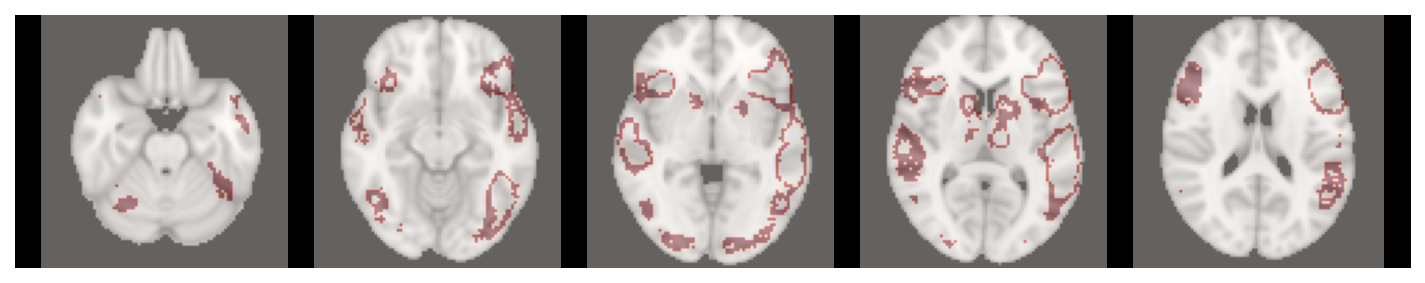

In [19]:
from scipy.ndimage import rotate
import nibabel as nib
import numpy as np
import re
import matplotlib.pyplot as plt

# Define the activation files
activation_files = [
    'images/Contrast1_p05_SecondGenP.nii.gz'
]

# Load the anatomical image
img = nib.load('anatomical.nii.gz')
data = img.get_fdata()

# Define slices to extract
slices_indices = [24, 30, 35, 40, 45]

# Set up the figure
fig, axes = plt.subplots(len(activation_files), len(slices_indices), figsize=(12, 9), dpi=150)

# Loop through activation files
for row, activation_file in enumerate(activation_files):
    # Load activation data
    activation = nib.load(activation_file)
    activation_data = PowerImage1#activation.get_fdata()
    
    # Loop through slices
    for col, slice_idx in enumerate(slices_indices):
        slice_img = data[:, :, slice_idx]
        activation_img = activation_data[:, :, slice_idx]
        
        # Rotate images by 90 degrees
        rotated_slice = rotate(slice_img, 90, reshape=False, mode='constant', cval=0)
        rotated_activation = rotate(activation_img, 90, reshape=False, mode='constant', cval=0)
        
        ax = axes[row, col] if len(activation_files) > 1 else axes[col]
        ax.imshow(rotated_slice, cmap='gray')
        ax.imshow(np.ma.masked_where(rotated_activation == 0, rotated_activation), cmap='Reds', alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)

plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.show()
